In [1]:
!nvidia-smi

Thu Dec  2 10:40:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Modules

In [2]:
import torch

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import pandas as pd

from torch.cuda import is_available
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split, Dataset

%matplotlib inline

In [3]:
device='cuda' if is_available() else 'cpu'

# Download dataset and calculate means and stds

In [4]:
all_data=CIFAR10(root='.',train=True,transform=transforms.ToTensor(),download=True)

meanRGB=[np.mean(x.numpy(),axis=(1,2)) for x,_ in all_data]
stdRGB=[np.std(x.numpy(),axis=(1,2)) for x,_ in all_data]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

print('Mean:',meanR, meanG, meanB)
print('Std:',stdR, stdG, stdB)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Mean: 0.49139965 0.48215845 0.4465309
Std: 0.20220213 0.19931543 0.20086348


# Implement CustomSubset
To use different augmentations to train subset and validation subset

In [5]:
class CustomSubset(Dataset):
    def __init__(self,Subset,transform=None):
        super(CustomSubset,self).__init__()
        self.Subset=Subset
        self.indices=Subset.indices
        self.transform=transform

    def __len__(self):
        return len(self.Subset)

    def __getitem__(self,idx):
        img,label=self.Subset[idx]
        if self.transform is not None:
            img=self.transform(img)
        return img,label

In [6]:
transform={
    'train':transforms.Compose([
                                transforms.Resize((256,256)),
                                transforms.RandomResizedCrop((227,227)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([meanR,meanG,meanB],[stdR,stdG,stdB])
            ]),
    'test':transforms.Compose([
                               transforms.Resize((256,256)),
                               transforms.CenterCrop((227,227)), # The paper used FiveCrop((227,227))
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize([meanR,meanG,meanB],[stdR,stdG,stdB])
            ])
}

train_ratio=0.8
train_data_len=int(len(all_data)*0.8)
valid_data_len=len(all_data)-train_data_len

train_data,valid_data=random_split(all_data,[train_data_len,valid_data_len])

all_data.transform=None
train_data=CustomSubset(train_data,transform['train'])
valid_data=CustomSubset(valid_data,transform['test'])
test_data=CIFAR10(root='.',train=False,transform=transform['test'],download=True)

Files already downloaded and verified


In [7]:
idx_to_class={0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

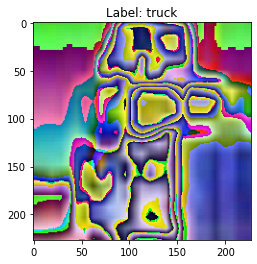

In [8]:
img=transforms.ToPILImage()(train_data[0][0])

plt.title('Label: {}'.format(idx_to_class[train_data[0][1]]))
plt.imshow(img)

# Define a model

In [10]:
class AlexNet(nn.Module):
    def __init__(self,num_classes=1000):
        super(AlexNet,self).__init__()
        self.net=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=96,kernel_size=11,stride=4,padding=0),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5,alpha=0.0001,beta=0.75,k=2.0),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(in_channels=96,out_channels=256,kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5,alpha=0.0001,beta=0.75,k=2.0),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384,out_channels=384,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2)
        )
        self.fc=nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256*6*6,out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096,out_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096,out_features=num_classes)
        )

        #self.init_weights() Initializing weights causes poor performance

    def forward(self,x):
        x=self.net(x)
        x=torch.flatten(x,1)
        x=self.fc(x)
        return x

    def init_weights(self):
        for layer in self.net:
            if isinstance(layer,nn.Conv2d):
                nn.init.normal_(layer.weight,mean=0,std=0.01)
        for layer in self.fc:
            if isinstance(layer,nn.Linear):
                nn.init.normal_(layer.weight,mean=0,std=0.01)
        nn.init.constant_(self.net[0].bias,0)
        nn.init.constant_(self.net[4].bias,1)
        nn.init.constant_(self.net[8].bias,0)
        nn.init.constant_(self.net[10].bias,1)
        nn.init.constant_(self.net[12].bias,1)
        nn.init.constant_(self.fc[1].bias,1)
        nn.init.constant_(self.fc[4].bias,1)
        nn.init.constant_(self.fc[6].bias,1)

# Prepare training step

In [9]:
batch_size=128

train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True)
valid_loader=DataLoader(valid_data,batch_size=batch_size,shuffle=False)
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [11]:
model=AlexNet(num_classes=10)
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.01,momentum=0.9,weight_decay=0.0005)

model=model.to(device)
criterion=criterion.to(device)

In [12]:
print(model)

AlexNet(
  (net): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2.0)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2.0)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_

# Train and validation
The training step proceeded about 31 epochs of 50 epochs due to colab GPU limitations

In [13]:
def train(model,criterion,optimizer,train_loader,valid_loader,num_epochs=10,print_every=1,early_stop=None,model_path='alexnet.pth'):
    train_logs={'Loss':[],'Accuracy':[]}
    valid_logs={'Loss':[],'Accuracy':[]}
    patience=0
    best_acc=-np.inf
    for epoch in range(num_epochs):
        train_loss=0
        valid_loss=0
        train_acc=0
        valid_acc=0
        # training step
        model.train()
        for data,target in train_loader:
            optimizer.zero_grad()
            data,target=data.to(device),target.to(device)
            pred=model(data)
            loss=criterion(pred,target)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()*data.size(0)
            train_acc+=torch.sum(pred.argmax(1)==target).item()
        train_loss/=len(train_data)
        train_acc/=len(train_data)
        train_logs['Loss'].append(train_loss)
        train_logs['Accuracy'].append(train_acc)
        if (epoch+1)%print_every==0:
            print('Training   Epoch {} - Loss : {:.8f} Accuracy : {:.4f}%'.format(epoch,train_loss,train_acc*100))
        # validation step
        with torch.no_grad():
            model.eval()
            for data,target in valid_loader:
                data,target=data.to(device),target.to(device)
                pred=model(data)
                loss=criterion(pred,target)
                valid_loss+=loss.item()*data.size(0)
                valid_acc+=torch.sum(pred.argmax(1)==target).item()
            valid_loss/=len(valid_data)
            valid_acc/=len(valid_data)
            valid_logs['Loss'].append(valid_loss)
            valid_logs['Accuracy'].append(valid_acc)
            if (epoch+1)%print_every==0:
                print('Validation Epoch {} - Loss : {:.8f} Accuracy : {:.4f}%'.format(epoch,valid_loss,valid_acc*100))
            if valid_acc>best_acc:
                best_acc=valid_acc
                torch.save(model.state_dict(),model_path)
                if early_stop is not None:
                    patience=0
            elif early_stop is not None:
                patience+=1
                if patience>=early_stop:
                    print('Training finished by early stopping')
                    return train_logs,valid_logs
    return train_logs,valid_logs

In [ ]:
train_logs,valid_logs = train(model=model,
                              criterion=criterion,
                              optimizer=optimizer,
                              train_loader=train_loader,
                              valid_loader=valid_loader,
                              num_epochs=50,
                              print_every=1,
                              early_stop=None,
                              model_path='alexnet.pth')

Training   Epoch 0 - Loss : 2.25136359 Accuracy : 13.6750%
Validation Epoch 0 - Loss : 2.07505543 Accuracy : 23.2000%
Training   Epoch 1 - Loss : 2.00273201 Accuracy : 23.9100%
Validation Epoch 1 - Loss : 1.77131635 Accuracy : 32.6900%
Training   Epoch 2 - Loss : 1.83550126 Accuracy : 30.6500%
Validation Epoch 2 - Loss : 1.56314264 Accuracy : 41.7500%
Training   Epoch 3 - Loss : 1.72451177 Accuracy : 35.6475%
Validation Epoch 3 - Loss : 1.46722588 Accuracy : 45.0100%
Training   Epoch 4 - Loss : 1.65668956 Accuracy : 38.3475%
Validation Epoch 4 - Loss : 1.33585610 Accuracy : 51.3900%
Training   Epoch 5 - Loss : 1.58020286 Accuracy : 41.8200%
Validation Epoch 5 - Loss : 1.26668878 Accuracy : 54.0600%
Training   Epoch 6 - Loss : 1.50787700 Accuracy : 44.8600%
Validation Epoch 6 - Loss : 1.14529895 Accuracy : 59.5600%
Training   Epoch 7 - Loss : 1.42470156 Accuracy : 48.5700%
Validation Epoch 7 - Loss : 1.17698888 Accuracy : 58.2600%
Training   Epoch 8 - Loss : 1.36114937 Accuracy : 50.762

In [ ]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot([i for i in range(len(train_logs['Loss']))],train_logs['Loss'],label='train_loss')
plt.plot([i for i in range(len(valid_logs['Loss']))],valid_logs['Loss'],label='valid_loss')
plt.legend()
plt.show()

In [ ]:
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot([i for i in range(len(train_logs['Accuracy']))],train_logs['Accuracy'],label='train_acc')
plt.plot([i for i in range(len(valid_logs['Accuracy']))],valid_logs['Accuracy'],label='valid_acc')
plt.legend()
plt.show()

# Test
The test was conducted by loading a model trained up to 31 epochs.

In [14]:
model.load_state_dict(torch.load('alexnet.pth'))
model=model.to(device)

In [15]:
def test(model,criterion,test_loader):
    test_loss=0
    test_acc=0
    result_table=pd.DataFrame(columns=['Prediction','Target'])
    with torch.no_grad():
        model.eval()
        for data,target in test_loader:
            data,target=data.to(device),target.to(device)
            pred=model(data)
            loss=criterion(pred,target)
            test_loss+=loss.item()*data.size(0)
            test_acc+=torch.sum(pred.argmax(1)==target).item()
            for p,t in zip(pred.argmax(1),target):
                result_table=result_table.append({'Prediction':p.item(),'Target':t.item()},ignore_index=True)
        test_loss/=len(test_data)
        test_acc/=len(test_data)
    return test_loss,test_acc,result_table

In [16]:
test_loss,test_acc,result_table=test(model=model,
                                     criterion=criterion,
                                     test_loader=test_loader)

In [17]:
print('Test Loss : {:.8f} Test Accuracy : {:.4f}%'.format(test_loss,test_acc*100))

Test Loss : 0.48183447 Test Accuracy : 83.1500%


In [18]:
result_table

,Prediction,Target
0,3,3
1,8,8
2,8,8
3,0,0
4,6,6
...,...,...
9995,8,8
9996,3,3
9997,5,5
9998,1,1


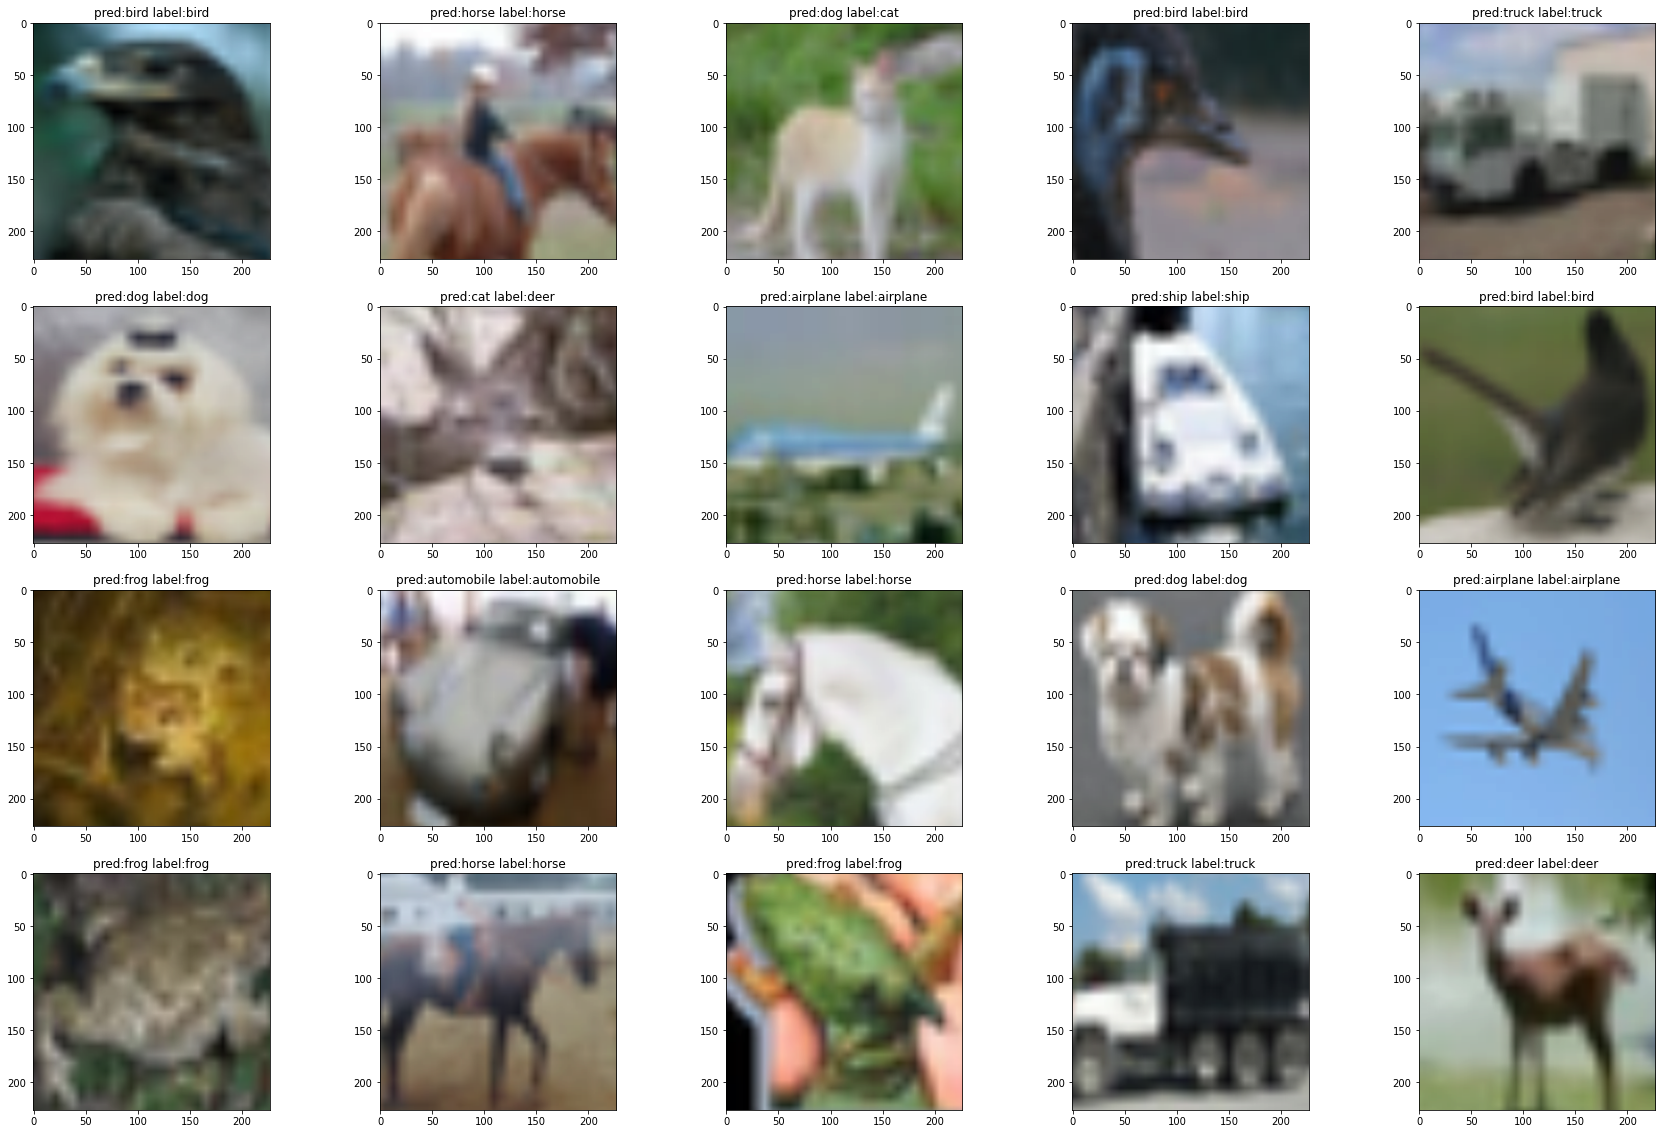

In [19]:
unNormalizeAndToImage=transforms.Compose([transforms.Normalize([-meanR/stdR,-meanG/stdG,-meanB/stdB],[1.0/stdR,1.0/stdG,1.0/stdB]),
                                          transforms.ToPILImage()])
fig=plt.figure(figsize=(30,20))
cols=5
rows=4
sample_index=np.random.randint(0,len(test_data),size=(cols*rows))

for i in range(1,cols*rows+1):
    img=unNormalizeAndToImage(test_data[sample_index[i-1]][0])
    pred=model(test_data[sample_index[i-1]][0].unsqueeze(0).to(device))
    fig.add_subplot(rows,cols,i)
    plt.title('pred:{} label:{}'.format(idx_to_class[pred.argmax().cpu().item()],idx_to_class[test_data[sample_index[i-1]][1]]))
    plt.imshow(img,cmap='gray')
plt.show()